In [1]:
import gzip
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import shutil

# Inspect full image archive without extracting all files

In [2]:
zipf = zipfile.ZipFile('Img/img.zip') # not using high-res images to simplify data wrangling

In [3]:
filenames = zipf.namelist()
df = pd.DataFrame([x.split('/') for x in filenames[:]], columns=['root_path', 'product_name', 'filename'])
df['path'] = filenames

In [4]:
df = df.dropna()
df = df[df.filename != '']
df = df.reset_index()
print(len(df))
df.sample(n=10)

289229


,index,root_path,product_name,filename,path
262976,268118,img,Tie-Dye_Bodycon_Cami_Dress,img_00000030.jpg,img/Tie-Dye_Bodycon_Cami_Dress/img_00000030.jpg
37315,38026,img,Buttoned_Geo_Jumpsuit,img_00000051.jpg,img/Buttoned_Geo_Jumpsuit/img_00000051.jpg
226836,231294,img,Sheer_Lace_&_Chiffon_Blouse,img_00000020.jpg,img/Sheer_Lace_&_Chiffon_Blouse/img_00000020.jpg
199448,203369,img,Peter_Pan_Collar_Lace_Dress,img_00000018.jpg,img/Peter_Pan_Collar_Lace_Dress/img_00000018.jpg
274701,280061,img,Twisted_Open-Back_Tee,img_00000051.jpg,img/Twisted_Open-Back_Tee/img_00000051.jpg
205447,209475,img,Pleated_Polka_Dot_Dress,img_00000018.jpg,img/Pleated_Polka_Dot_Dress/img_00000018.jpg
237810,242502,img,Splattered_Stripe_Maxi_Dress,img_00000035.jpg,img/Splattered_Stripe_Maxi_Dress/img_00000035.jpg
258545,263609,img,Textured_Boyfriend_Blazer,img_00000068.jpg,img/Textured_Boyfriend_Blazer/img_00000068.jpg
141368,144015,img,Heathered_Open-Front_Cardigan,img_00000016.jpg,img/Heathered_Open-Front_Cardigan/img_00000016...
11506,11756,img,Animal_Print_Satin_Blouse,img_00000045.jpg,img/Animal_Print_Satin_Blouse/img_00000045.jpg


In [5]:
osize = 0 
for item in zipf.infolist():
    osize += item.file_size
print('uncompressed size =',round(osize/1000000000,2),'GB')

uncompressed size = 2.74 GB


# Basic EDA

### Number of product types (each image file is a unique product)

In [6]:
# Number of unique products
products = np.unique(df.product_name)
len(products)

5621

In [7]:
def flattenTypes(val):
    lst = val.split('_')
    return lst[-1]

In [8]:
df['product_type'] = df.product_name.apply(flattenTypes)
all_cats = np.unique(df.product_type)
print(len(all_cats))
all_cats

46


array(['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Caftan',
       'Capris', 'Cardigan', 'Chinos', 'Coat', 'Coverup', 'Culottes',
       'Cutoffs', 'Dress', 'Flannel', 'Gauchos', 'Halter', 'Henley',
       'Hoodie', 'Jacket', 'Jeans', 'Jeggings', 'Jersey', 'Jodhpurs',
       'Joggers', 'Jumpsuit', 'Kaftan', 'Kimono', 'Leggings', 'Onesie',
       'Parka', 'Peacoat', 'Poncho', 'Robe', 'Romper', 'Sarong', 'Shorts',
       'Skirt', 'Sweater', 'Sweatpants', 'Sweatshorts', 'Tank', 'Tee',
       'Top', 'Trunks', 'Turtleneck'], dtype=object)

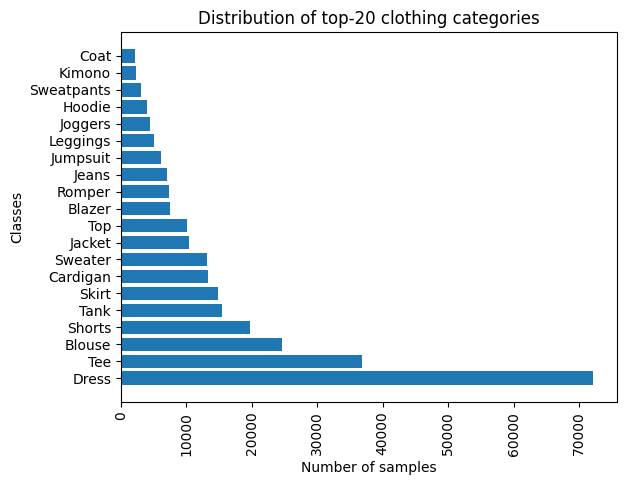

In [9]:
histdata = df.groupby(['product_type']).count()
histdata = histdata.sort_values(by='root_path', ascending=False)

data = histdata['root_path'][:20]
plt.barh(data.index, data.values)
plt.title('Distribution of top-20 clothing categories')
plt.xticks(rotation = 90)
plt.ylabel('Classes')
plt.xlabel('Number of samples')
plt.show()

In [10]:
histdata[histdata['root_path'] < 5000][-10:]

,index,root_path,product_name,filename,path
product_type,,,,,
Kaftan,126,126,126,126,126
Peacoat,97,97,97,97,97
Capris,77,77,77,77,77
Onesie,70,70,70,70,70
Caftan,54,54,54,54,54
Gauchos,49,49,49,49,49
Jodhpurs,45,45,45,45,45
Sarong,32,32,32,32,32
Halter,17,17,17,17,17


### Load the bounding box data and merge with the file list

In [11]:
# read in the bounding box dataset for all records
f = open('Anno_coarse/list_bbox.txt')
boxes = f.readlines()
boxes = boxes[2:]
boxes = [x.replace('\n', '') for x in boxes]
#boxes = [x.replace('img/', 'img_highres/') for x in boxes]
boxes = [' '.join(x.split()).split() for x in boxes]
df_boxes = pd.DataFrame(boxes, columns=['path', 'x1', 'y1', 'x2', 'y2'])
df_boxes.head()

,path,x1,y1,x2,y2
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,072,079,232,273
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,067,059,155,161
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,065,065,156,200
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,051,062,167,182
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,046,088,166,262


In [12]:
df_all = df.merge(df_boxes, on='path')
df_all.sample(5)

,index,root_path,product_name,filename,path,product_type,x1,y1,x2,y2
81351,82886,img,Daisy_Crochet_Cardigan,img_00000041.jpg,img/Daisy_Crochet_Cardigan/img_00000041.jpg,Cardigan,012,034,294,276
122489,124761,img,Floral_Lace_Pencil_Skirt,img_00000066.jpg,img/Floral_Lace_Pencil_Skirt/img_00000066.jpg,Skirt,001,001,212,264
209263,213359,img,Quilted_&_Hooded_Utility_Jacket,img_00000029.jpg,img/Quilted_&_Hooded_Utility_Jacket/img_000000...,Jacket,040,072,227,300
78092,79569,img,Curved_Hem_Ribbed_Tank,img_00000023.jpg,img/Curved_Hem_Ribbed_Tank/img_00000023.jpg,Tank,031,054,145,199
171280,174538,img,Low-Rise_-__Mineral_Wash_Jeans,img_00000014.jpg,img/Low-Rise_-__Mineral_Wash_Jeans/img_0000001...,Jeans,076,001,156,221


### Inspect a few sample images and corresponding bounding boxes

In [13]:
toplot = df_all[df_all.product_name=='Scalloped_Halter_Dress'][:10]

In [14]:
# extract sample images from archive to disk
filelist = toplot.path.values
zipf.extractall(path='temp/', members=filelist)

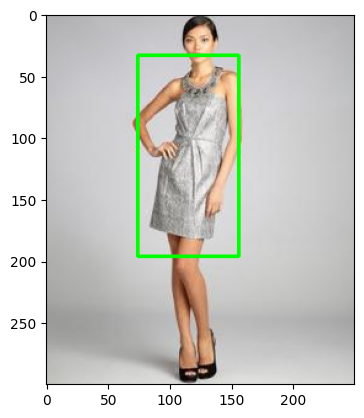

In [15]:
row = toplot.iloc[8].values
img = cv2.imread('temp/'+row[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
(x1, y1, x2, y2) = [int(x) for x in row[-4:]]
img_bbox = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)
plt.show()

# Prepare subset of overall data based on specific categories of products

### Sample files in categories

In [16]:
cats = ['Tee', 'Blouse', 'Shorts', 'Jeans']
subset = df_all[df_all.product_type.isin(cats)]

In [17]:
# numitems is used to determine the category with the smallest number of items
numitems = min(subset.groupby('product_type').count().path)

In [18]:
# then we sample numitems * 70% in each of the cateogries to leave images for later validation and/or testing
subsample = subset.groupby('product_type').sample(n=int(numitems*.7))
len(subsample)

19812

In [19]:
# Extract all the sample files from the zipped archive to disk
filelist = subsample.path.values
zipf.extractall(path='fashion/', members=filelist)

### Determine dimensions and remove samples not meeting criteria

In [20]:
# determine the dimensions of each image
# this is necessary for YOLOv5 training, where we have to specify a "longest" dimension for the training
dims = []
for file in filelist[:]:
    i = Image.open('fashion/'+file)
    dims.append([*i.size])
dims_df = pd.DataFrame(dims, columns=['i_w', 'i_h'])

In [21]:
most_common_w = dims_df.groupby('i_w').count().sort_values(by='i_h', ascending=False).iloc[:1]
most_common_h = dims_df.groupby('i_h').count().sort_values(by='i_w', ascending=False).iloc[:1]
print(most_common_w)
print(most_common_h)

      i_h
i_w      
300  5907
       i_w
i_h       
300  14525


In [22]:
most_common_dim = 300

In [23]:
subsample = pd.concat([subsample.reset_index(drop=True), dims_df.reset_index(drop=True)], axis=1)

In [24]:
# determine which images are outside the range of the 
toobig = subsample[(subsample['i_w'] > most_common_dim) | (subsample['i_h'] > most_common_dim)]
toosmall = subsample[(subsample['i_w'] < most_common_dim) & (subsample['i_h'] < most_common_dim)]
print(len(toobig), len(toosmall))

1236 2566


In [25]:
toobig.groupby('product_type').count()['path'] + toosmall.groupby('product_type').count()['path']

product_type
Blouse     976
Jeans      806
Shorts    1002
Tee       1018
Name: path, dtype: int64

In [26]:
subsample = subsample[~subsample.path.isin(toobig.path)]
subsample = subsample[~subsample.path.isin(toosmall.path)]
subsample.head()

,index,root_path,product_name,filename,path,product_type,x1,y1,x2,y2,i_w,i_h
0,153618,img,Ikat_Print_Chiffon_Blouse,img_00000077.jpg,img/Ikat_Print_Chiffon_Blouse/img_00000077.jpg,Blouse,056,045,241,278,300,300
1,224642,img,Ruffled_Rose_Blouse,img_00000012.jpg,img/Ruffled_Rose_Blouse/img_00000012.jpg,Blouse,033,059,112,144,137,300
3,230962,img,Sheer_Abstract_Print_Blouse,img_00000068.jpg,img/Sheer_Abstract_Print_Blouse/img_00000068.jpg,Blouse,031,090,144,276,205,300
4,160096,img,Lace-Paneled_Pintucked_Blouse,img_00000020.jpg,img/Lace-Paneled_Pintucked_Blouse/img_00000020...,Blouse,015,071,193,176,193,300
5,224221,img,Ruffled_Floral_Chiffon_Blouse,img_00000072.jpg,img/Ruffled_Floral_Chiffon_Blouse/img_00000072...,Blouse,017,071,185,276,210,300


In [27]:
# is it still balanced across classes?
subsample.groupby('product_type').count()['path']

product_type
Blouse    3977
Jeans     4147
Shorts    3951
Tee       3935
Name: path, dtype: int64

In [28]:
# remove images from disk that are not within required size (300px on one or more dimensions)
for file in toobig.path.values:
    os.remove('fashion/'+file)
    
for file in toosmall.path.values:
    os.remove('fashion/'+file)

### Prepare additional fields for YOLOv5 label data format

In [29]:
# calculate the elements needed for the YOLOv5 PyTorch training input labels/
subsample.x1 = subsample.x1.astype(int)
subsample.y1 = subsample.y1.astype(int)
subsample.x2 = subsample.x2.astype(int)
subsample.y2 = subsample.y2.astype(int)
subsample.i_w = subsample.i_w.astype(int)
subsample.i_h = subsample.i_h.astype(int)

subsample['x'] = subsample.apply(lambda row: (((row.x2 - row.x1)/2) + row.x1) / row.i_w, axis=1)
subsample['y'] = subsample.apply(lambda row: (((row.y2 - row.y1)/2) + row.y1) / row.i_h, axis=1)
subsample['w'] = subsample.apply(lambda row: (row.x2 - row.x1) / row.i_w, axis=1)
subsample['h'] = subsample.apply(lambda row: (row.y2 - row.y1) / row.i_h, axis=1)
subsample.head()

,index,root_path,product_name,filename,path,product_type,x1,y1,x2,y2,i_w,i_h,x,y,w,h
0,153618,img,Ikat_Print_Chiffon_Blouse,img_00000077.jpg,img/Ikat_Print_Chiffon_Blouse/img_00000077.jpg,Blouse,56,45,241,278,300,300,0.495000,0.538333,0.616667,0.776667
1,224642,img,Ruffled_Rose_Blouse,img_00000012.jpg,img/Ruffled_Rose_Blouse/img_00000012.jpg,Blouse,33,59,112,144,137,300,0.529197,0.338333,0.576642,0.283333
3,230962,img,Sheer_Abstract_Print_Blouse,img_00000068.jpg,img/Sheer_Abstract_Print_Blouse/img_00000068.jpg,Blouse,31,90,144,276,205,300,0.426829,0.610000,0.551220,0.620000
4,160096,img,Lace-Paneled_Pintucked_Blouse,img_00000020.jpg,img/Lace-Paneled_Pintucked_Blouse/img_00000020...,Blouse,15,71,193,176,193,300,0.538860,0.411667,0.922280,0.350000
5,224221,img,Ruffled_Floral_Chiffon_Blouse,img_00000072.jpg,img/Ruffled_Floral_Chiffon_Blouse/img_00000072...,Blouse,17,71,185,276,210,300,0.480952,0.578333,0.800000,0.683333


### Verify reconstruction of bboxes

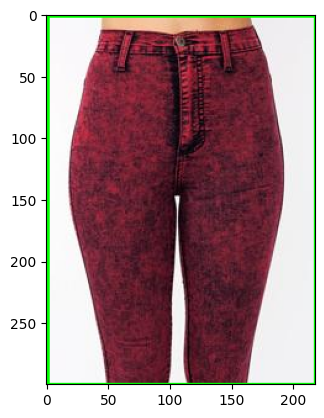

In [30]:
# visually inspect some manually chosen random items
row = subsample.iloc[5000].values
img = cv2.imread('fashion/'+row[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
(i_w, i_h, x, y, w, h) = row[-6:]
# reconstruct the bboxes
x1 = int((x-w/2)*i_w)
y1 = int((y-h/2)*i_h)
x2 = int((x+w/2)*i_w)
y2 = int((y+h/2)*i_h)
img_bbox = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)
plt.show()

### Create label/*.txt and data.yaml files

In [31]:
# create 1 label file for each image
for i, entry in subsample.iterrows():
    # see YOLOv5 pytorch data format:  class x_center y_center width height
    idx = cats.index(entry.product_type)
    metadata = str(idx)+' ' + ' '.join([str(round(x,3)) for x in entry.iloc[-4:]])    
    filepath = entry.path.split('.')[0]
    fileroot = 'fashion/labels/'+filepath
    
    if not os.path.exists(os.path.dirname(fileroot)):
        try:
            os.makedirs(os.path.dirname(fileroot))
        except: # Guard against race condition
            print(problem)
            raise
    
    f = open(fileroot+'.txt', 'w')
    f.write(metadata)
    f.close()

In [32]:
lines = []
lines.append('path: ../datasets/fashion # root dir\n')
lines.append('train: images/train\n')
lines.append('val: images/val\n')
lines.append('test:  # test images (optional)\n')

lines.append('nc: '+str(len(cats))+' # number of classes\n')

str_classes = "[ '" + "',\n'".join(cats) + "' ]"

lines.append('names: '+str_classes + '\n')

f = open('fashion/fashion.yaml', 'w')
f.writelines(lines)
f.close()

# Split into Train/Val

In [33]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(subsample, test_size=0.2)

In [34]:
if not os.path.exists('fashion/images'):
    os.mkdir('fashion/images')
if not os.path.exists('fashion/images/train'):
    os.mkdir('fashion/images/train')
if not os.path.exists('fashion/images/val'):
    os.mkdir('fashion/images/val')

if not os.path.exists('fashion/labels'):
    os.mkdir('fashion/labels')
if not os.path.exists('fashion/labels/train'):
    os.mkdir('fashion/labels/train')
if not os.path.exists('fashion/labels/val'):
    os.mkdir('fashion/labels/val')

In [35]:
for i, file in val.iterrows():
    base=file.path
    src = 'fashion/'+base
    dest = 'fashion/images/val/'+base.replace('img/', '')
    folder = 'fashion/images/val/' + '/'.join(base.split('/')[1:-1])
    if not os.path.exists(folder):
        os.mkdir(folder)
    try:
        shutil.move(src, dest)
    except:
        print('error on ',src)

    lbl_base = base.split('.')[0]+'.txt'
    lbl_src = 'fashion/labels/'+lbl_base
    lbl_dest = 'fashion/labels/val/'+lbl_base.replace('img/', '')
    folder = 'fashion/labels/val/' + '/'.join(base.split('/')[1:-1])
    if not os.path.exists(folder):
        os.mkdir(folder)
    try:
        shutil.move(lbl_src, lbl_dest)
    except:
        print('error on ',src)

error on  fashion/img/L.A.T.H.C._Layered-Hem_Longline_Tee/img_00000008.jpg
error on  fashion/img/EPTM._Slub_Knit_Longline_Tee/img_00000004.jpg
error on  fashion/img/L.A.T.H.C._Graphic_Drawstring_Shorts/img_00000021.jpg
error on  fashion/img/EPTM._Longline_Mesh_Tee/img_00000021.jpg
error on  fashion/img/EPTM._Quilted_Shorts/img_00000006.jpg
error on  fashion/img/L.A._Graphic_Tee/img_00000022.jpg
error on  fashion/img/Notorious_B.I.G._Graphic_Tee/img_00000055.jpg
error on  fashion/img/L.A._Graphic_Tee/img_00000081.jpg


# Cleanup remaining paths and create .zip for YOLOv5 training

In [36]:
!mv fashion/img/* fashion/images/train
!rm -r fashion/img

In [37]:
!mv fashion/labels/img/* fashion/labels/train
!rm -r fashion/labels/img

In [38]:
!zip -r -q fashion.zip fashion

# Next

- Load the zip file to the yolov5/pytorch training environment in path datasets/ (to create).
- Unzip the file
- Copy or move the .yaml file to the path yolov5/data/ (expected by train.py from yolov5).  This path is available after running the setup notebook cell which clones the yolov5 repo.